# Pipeline for the anomaly detection on the SKAB using ARIMA fault detection algorithm

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

The idea behind this algorithm is to use ARIMA weights as features for the anomaly detection algorithm. Using discrete differences of weight coefficients for different heuristic methods for obtaining function, which characterized the state (anomaly, not anomaly) using a threshold. 

Links at [PyPi](https://pypi.org/project/arimafd/), [GitHub](https://github.com/waico/arimafd) and [paper](https://waico.ru)

In [ ]:
# libraries importing
import sys
import warnings

import pandas as pd
from arimafd import Arima_anomaly_detection

sys.path.append("..")
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
Xy_traintest_list = load_preprocess_skab()

## Method

In [ ]:
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    model = Arima_anomaly_detection()
    model.fit(X_train)
    prediction = pd.Series(
        model.predict(X_test),
        index=X_test.index,
    )

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

### Results visualization

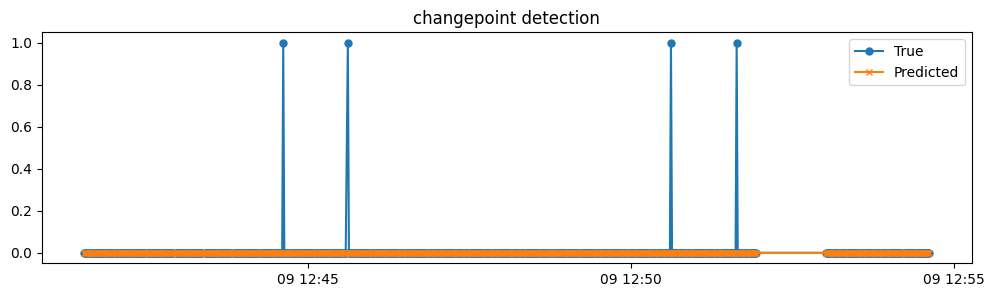

In [ ]:
# [donotremove]
plot_results(
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [ ]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 0.01 %
Missing Alarm Rate 100.0 %
F1 metric 0.0


not implemented

### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 127
A number of FPs = 2
Average time nan


/Users/mw/pyprojects/SKAB/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/SKAB/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  -0.09
LowFP  -  -0.17
LowFN  -  -0.06
